In [1]:
from pathlib import Path
import sys

repo_root = Path.cwd().parent           # .. from notebooks/
sys.path.insert(0, str(repo_root))      # make the repo importable

import pairs
print(pairs.__file__)


/home/mengren/projects/dynamic-hedge-pairs-trading-main/pairs/__init__.py


In [2]:
# From notebooks/ → install the package from the repo root (one level up)
%pip install -e "..[notebooks]"  # or just ".." if you didn’t define the [notebooks] extra

Obtaining file:///home/mengren/projects/dynamic-hedge-pairs-trading-main
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for pairs-trading (pyproject.toml) ... done
  Created wheel for pairs-trading: filename=pairs_trading-0.1.0-0.editable-py3-none-any.whl size=4994 sha256=7fb907635209a87ace451d7568a6cf1c963867c6d1e3a12203f7e7c917e909e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-p0kyrf6n/wheels/57/27/7a/50dab0174b306d31d8442aa5fad9ad97bd341d756bf5d5b6b1
Successfully built pairs-trading
  Attempting uninstall: pairs-trading
    Found existing installation: pairs-trading 0.1.0
    Uninstalling pairs-trading-0.1.0:
      Successfully uninstalled pairs-trading-0.1.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys, importlib.util
print(sys.executable)
print(importlib.util.find_spec("pairs"))
import pairs
print(pairs.__version__)
print(pairs.__file__)

/home/mengren/anaconda3/envs/pairs/bin/python
ModuleSpec(name='pairs', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7178602642b0>, origin='/home/mengren/projects/dynamic-hedge-pairs-trading-main/pairs/__init__.py', submodule_search_locations=['/home/mengren/projects/dynamic-hedge-pairs-trading-main/pairs'])
0+unknown
/home/mengren/projects/dynamic-hedge-pairs-trading-main/pairs/__init__.py


# 1. Download historical data using openbb

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# In a notebook under notebooks/
from pairs import load_universe

tickers = load_universe("spx_ndx_combined")  # returns a pandas.Index (UPPERCASE, deduped)
# tickers = load_universe("ndx")
print(len(tickers), tickers[:10].tolist())   # quick peek


517 ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM']


In [6]:
from pairs import load_prices, download_openbb

In [7]:
start_date="2020-01-01"
end_date="2025-01-01"

# df, failed = download_openbb(tickers, start_date, end_date, return_failed=True)
df_train, failed = load_prices('openbb', tickers, start_date, end_date, return_failed=True)

# print(df_train.head())
if failed:
    print("No data for:", failed)

ZTS: 100%|██████████| 517/517 [02:27<00:00,  3.50it/s]  

No data for: ['BF.B', 'BRK.B']


In [8]:
df_train

open        high         low       close   volume  \
ticker datetime                                                              
A      2020-01-02   85.900002   86.349998   85.199997   85.949997  1410500   
       2020-01-03   84.669998   85.330002   84.500000   84.570000  1118300   
       2020-01-06   84.000000   84.820000   83.599998   84.820000  1993200   
       2020-01-07   83.959999   85.260002   83.940002   85.080002  1684700   
       2020-01-08   85.959999   86.470001   85.199997   85.919998  1847600   
...                       ...         ...         ...         ...      ...   
ZTS    2024-12-24  163.699997  165.039993  162.740005  164.699997  1023600   
       2024-12-26  163.720001  165.789993  163.020004  165.520004  2167200   
       2024-12-27  164.949997  166.529999  163.520004  164.600006  1800100   
       2024-12-30  163.889999  164.050003  161.449997  162.240005  1531400   
       2024-12-31  162.899994  163.750000  161.869995  162.929993  1327400   

                   dividend  split_ratio  
ticker datetime                           
A      2020-01-02       0.0          NaN  
       2020-01-03       0.0          NaN  
       2020-01-06       0.0          NaN  
       2020-01-07       0.0          NaN  
       2020-01-08       0.0          NaN  
...                     ...          ...  
ZTS    2024-12-24       0.0          NaN  
       2024-12-26       0.0          NaN  
       2024-12-27       0.0          NaN  
       2024-12-30       0.0          NaN  
       2024-12-31       0.0          NaN  

[639611 rows x 7 columns]

## 1.1 Pre-filter for Data Quality

We keep tickers whose coverage matches the global coverage

In [9]:
import pandas as pd

# infer level names/positions
lvl_names = list(df_train.index.names)
ticker_lvl = 0                                  # you said ticker is first level
time_lvl_name = 'datetime' if 'datetime' in lvl_names else lvl_names[1]

# global time span
full_start = df_train.index.get_level_values(time_lvl_name).min()
full_end   = df_train.index.get_level_values(time_lvl_name).max()

# per-ticker start/end
starts = df_train.groupby(level=ticker_lvl).apply(
    lambda g: g.index.get_level_values(time_lvl_name).min()
)
ends = df_train.groupby(level=ticker_lvl).apply(
    lambda g: g.index.get_level_values(time_lvl_name).max()
)

# tickers whose coverage matches the global coverage
tickers_to_keep = starts[(starts == full_start) & (ends == full_end)].index

# filter df by those tickers
df_filtered = df_train.loc[pd.IndexSlice[tickers_to_keep, :]]

The original number of tickers, *vs.* the number of tickers matching the global coverage

In [10]:
len(df_train.index.get_level_values('ticker').unique()), len(df_filtered.index.get_level_values('ticker').unique())

(515, 499)

Below is the set of tickers whose time coverages are shorter than the global coverage

In [11]:
set(tickers) - set(df_filtered.index.get_level_values('ticker').unique())

{'ABNB',
 'APP',
 'ARM',
 'BF.B',
 'BRK.B',
 'CARR',
 'CEG',
 'COIN',
 'DASH',
 'EXE',
 'GEHC',
 'GEV',
 'GFS',
 'KVUE',
 'OTIS',
 'PLTR',
 'SOLV',
 'VLTO'}

# 2. Cointegration Screening

## 2.1 Initial Cointegration Screening

Here, we implement the following two cointegration tests
- Engle-Granger test, and
- Johansen test

In [12]:
from pairs import find_cointegrated_pairs_dualgate

summary_dual = find_cointegrated_pairs_dualgate(
    df_filtered,
    alpha_eg=0.05, eg_trend="c",
    alpha_joh=0.05, joh_det_order=0, joh_k_ar_diff=1, joh_stat="trace",
    n_workers=40, chunksize=8, show_progress=True
)

In [13]:
summary_dual.sample(20)

,,eg_t,eg_p,eg_pass,joh_stat,joh_pass,verdict
ticker1,ticker2,,,,,,
ABT,DGX,-3.051852,0.098389,False,16.439163,True,fail
MET,STX,-1.888081,0.586040,False,8.205644,False,fail
EQT,PCAR,-1.914948,0.572407,False,4.275525,False,fail
IR,ROK,-0.700265,0.946610,False,6.802932,False,fail
CTAS,KKR,-1.312201,0.826024,False,9.121188,False,fail
EMN,RF,-1.922812,0.568394,False,11.963724,False,fail
EBAY,FAST,-1.895354,0.582361,False,5.638032,False,fail
EQR,NI,-1.767543,0.645349,False,6.162958,False,fail
ACGL,DECK,-2.227082,0.410445,False,3.823652,False,fail


In [14]:
# summary_dual is what find_cointegrated_pairs_dualgate returns
tmp = summary_dual.copy()
tmp["rank_eg"]  = tmp["eg_p"].rank(method="average", ascending=True)
tmp["rank_joh"] = tmp["joh_stat"].rank(method="average", ascending=False)
# normalize to [0,1] and average
tmp["pre_score"] = 0.5*(tmp["rank_eg"]/tmp["rank_eg"].max()
                      + tmp["rank_joh"]/tmp["rank_joh"].max())
prelim = tmp.sort_values("pre_score", ascending=True)   # lower rank is better
# pick top N (e.g., 2–3× the number you intend to trade)
candidates = prelim.head(200).index.to_list()

In [15]:
prelim

eg_t          eg_p  eg_pass   joh_stat  joh_pass verdict  \
ticker1 ticker2                                                                 
CCL     TTWO    -6.250168  4.597262e-07     True  42.250921      True    pass   
NCLH    TTWO    -6.371451  2.461515e-07     True  39.980485      True    pass   
        NSC     -6.121224  8.850157e-07     True  38.021322      True    pass   
        TRMB    -6.266599  4.226243e-07     True  37.178857      True    pass   
CCL     SHOP    -6.470849  1.466481e-07     True  36.676596      True    pass   
...                   ...           ...      ...        ...       ...     ...   
AXP     OXY      0.582827  9.931300e-01    False   1.660159     False    fail   
AVGO    MPC      0.806872  9.938628e-01    False   2.467877     False    fail   
        COP      1.076664  1.000000e+00    False   2.797799     False    fail   
AMP     DVN      0.945155  1.000000e+00    False   2.757229     False    fail   
KKR     OXY      0.944967  1.000000e+00    False   2.508216     False    fail   

                  rank_eg  rank_joh  pre_score  
ticker1 ticker2                                 
CCL     TTWO          8.0      13.0   0.000085  
NCLH    TTWO          5.0      23.0   0.000113  
        NSC          12.0      40.0   0.000209  
        TRMB          7.0      52.0   0.000238  
CCL     SHOP          2.0      61.0   0.000254  
...                   ...       ...        ...  
AXP     OXY      122578.0  124207.0   0.995138  
AVGO    MPC      123018.0  123785.0   0.995217  
        COP      123737.5  123290.0   0.996133  
AMP     DVN      123737.5  123370.0   0.996455  
KKR     OXY      123737.5  123735.0   0.997924  

[124251 rows x 9 columns]

In [16]:
candidates

[('CCL', 'TTWO'),
 ('NCLH', 'TTWO'),
 ('NCLH', 'NSC'),
 ('NCLH', 'TRMB'),
 ('CCL', 'SHOP'),
 ('NCLH', 'WDAY'),
 ('NCLH', 'PDD'),
 ('NCLH', 'TER'),
 ('NCLH', 'TXN'),
 ('NCLH', 'SBUX'),
 ('NCLH', 'SHOP'),
 ('ABT', 'NSC'),
 ('CCL', 'EBAY'),
 ('NCLH', 'UDR'),
 ('NCLH', 'TDY'),
 ('CCL', 'COO'),
 ('NCLH', 'ZS'),
 ('NCLH', 'SW'),
 ('CCL', 'TRMB'),
 ('CCL', 'MELI'),
 ('NCLH', 'PPG'),
 ('NCLH', 'ZBRA'),
 ('NCLH', 'WEC'),
 ('CCL', 'ECL'),
 ('NCLH', 'ROK'),
 ('CCL', 'EA'),
 ('CCL', 'CTSH'),
 ('NCLH', 'TROW'),
 ('NCLH', 'STT'),
 ('CCL', 'FDX'),
 ('CCL', 'TYL'),
 ('NCLH', 'PNW'),
 ('NCLH', 'TEL'),
 ('NCLH', 'NWSA'),
 ('NCLH', 'VRSN'),
 ('CCL', 'TER'),
 ('GM', 'SW'),
 ('NCLH', 'TEAM'),
 ('CCL', 'WDAY'),
 ('NCLH', 'XYZ'),
 ('CCL', 'GM'),
 ('NCLH', 'UNP'),
 ('NCLH', 'NDSN'),
 ('NCLH', 'PODD'),
 ('NCLH', 'TTD'),
 ('CCL', 'PDD'),
 ('CCL', 'EMN'),
 ('CCL', 'EXPE'),
 ('MA', 'PH'),
 ('NCLH', 'XEL'),
 ('NCLH', 'TYL'),
 ('CCL', 'SW'),
 ('RCL', 'WMT'),
 ('NCLH', 'POOL'),
 ('CCL', 'ZBRA'),
 ('ABT', 'EMN'),
 ('

## 2.2 Kalman Filtering and Stationarity Tests on Residuals

In [17]:
from pairs import (
    fit_kalman_hedge,
    summarize_spread_stationarity_joblib,
)

### Overview: Dynamic Hedge via Kalman Filter

We model a time-varying hedge ratio between two assets with a linear Gaussian state-space model.

**State (random walk):**
$$
\theta_t = 
\begin{bmatrix}
\beta_t \\ \alpha_t
\end{bmatrix},
\qquad
\theta_t = \theta_{t-1} + w_t
$$
where $w_t\sim\mathcal{N}(0, Q)$.

**Observation:**
$$
y_t = \alpha_t + \beta_t x_t + v_t,
\qquad
v_t\sim\mathcal{N}(0, R).
$$

**Calibration:**
Expectation-Maximization (EM) can learn $Q$ (state noise) and $R$ (observation noise).



### Terminology

- **In-sample calibration** (often called "training"): learn $Q$, $R$ with EM and estiamte $(\alpha_t, \beta_t)$ on the train window.
- **Out-of-sample continuation**: continue **filtering** on the test window using the **last train state and learng $Q, R$.

Here, we perform in-sample calibration of a Kalman filter in the cell below.

In [18]:
# in-sample calibration of a Kalman filter
states_tr, params_tr = fit_kalman_hedge(
    df_train,
    pairs=candidates,
    mode="smooth",
    em_iters=5,          # modest EM to learn Q/R
    q=1e-5,              # slow drift
    n_workers=None,      # all CPUs
    chunksize=100,
    show_progress=True,
    return_params=True,  # ← get (states, params)
)

In [19]:
summary_stationarity = summarize_spread_stationarity_joblib(states_tr, alpha=0.05, regression="c", 
                                                            chunksize=256, show_progress=True)

In [20]:
summary_stationarity

adf_stat         adf_p  kpss_stat    kpss_p  halflife  \
ticker1 ticker2                                                           
NCLH    ZBH     -12.473904  3.199744e-23   0.500000  0.041667  0.623353   
        SJM     -11.099366  3.900236e-20   0.500000  0.041667  0.619043   
CCL     TTD     -19.525280  0.000000e+00   0.020838  0.100000  0.836463   
        MCHP    -19.649539  0.000000e+00   0.024466  0.100000  0.760413   
        MU      -17.815055  3.177767e-30   0.026000  0.100000  0.711484   
...                    ...           ...        ...       ...       ...   
BDX     CTRA     -9.059207  4.611970e-15   0.011067  0.100000  3.717803   
NCLH    PCG      -8.306838  3.883146e-13   0.146621  0.100000  4.290321   
BDX     T        -8.153646  9.547574e-13   0.010921  0.100000  3.155681   
        IPG      -7.836695  6.088293e-12   0.008038  0.100000  3.495079   
        F        -7.600671  2.394057e-11   0.019156  0.100000  8.527319   

                 resid_sigma    shapre       verdict  
ticker1 ticker2                                       
NCLH    ZBH         0.297637 -0.013053  inconclusive  
        SJM         0.293810 -0.025110  inconclusive  
CCL     TTD         0.432391 -0.075808    stationary  
        MCHP        0.387722 -0.033280    stationary  
        MU          0.352354 -0.036968    stationary  
...                      ...       ...           ...  
BDX     CTRA        5.915594 -0.009693    stationary  
NCLH    PCG         1.818570 -0.259087    stationary  
BDX     T           5.441019  0.002485    stationary  
        IPG         5.584079 -0.004402    stationary  
        F           9.040715 -0.026724    stationary  

[200 rows x 8 columns]

### Stationarity Test

The test runs, on each pair:
1. **ADF (Augmented Dickey-Fuller)** on the residual series $\varepsilon_t$ (aka spread, contained in states_tr from the cell above)
- adfuller (s, autolag="AIC", regression=regression)
- Returns adf_stat, adf_p, plus lags/crit (lags/crit not kept in the summary frame).
2. **KPSS** on the same series
- kpss(s, regression=("c" if regression=="c" else "ct"), nlags="auto")
- Returns kpss_stat, kpss_p.

**Verdict rule** (using alpha, default 0.05):
- If **ADF rejects** ($p<\alpha$) **and KPSS does not reject** ($p\geq\alpha$) $\to$ "stationary"
- If **ADF does not reject and KPSS rejects** $\to$ "non-stationary"
- Otherwise $\to$ "inconclusive"

**Extra diagnostics it computes**
- **Half-life** (quick AR-style proxy for mean reversion speed): Fits a slope on ($\varepsilon_{t-1}$ and $\Delta\varepsilon_t$, from the residual series) with np.polyfit and uses
$$
\mathrm{halflife} \approx -\frac{\ln 2}{\beta}
$$
(returns np.nan if unstable or slope is 0).

Here, $\varepsilon_{t-1}$ is the **previous-period residual**. In our setup,
$$
\varepsilon_t = P^{(1)}_t - (\alpha_t + \beta_t P^{(2)}_t),
$$
where $P^{(1)}$ and $P^{(2)}$ are the two price series

- **Residual sigma**: s.std() on the residual series $\varepsilon_t$. 

### Composite scoring to rank tradable pairs

The following cell takes the stationarity diagnostics and creates a **single composite score** per pair to rank candidates for trading. The idea is to convert heterogeneous metrics (p-values, half-life, residual scale, Sharpe) into comparable **z-scores**, align their direction (higher = better), and sum them with optional weights.

#### 1) Inputs and safeguards
- Start from summary_stationarity (ADF/KPSS results, half-life, standard deviation of residual series $\varepsilon_t$, optional sharpe_train) and copy to final_df.
- Coerce relevant columns to numeric to avoid dtype surprises.
- Provide a safe fallback for sharpe_train (zeros if the column is missing).
- **Clip** extreme values to keep transforms well-behaved:
    - adf_p, kpss_p are clipped to $[10^{-300}, 1]$ so $-\log_{10}(p)$ never hits infinity.
    - halflife is clipped at 0 so np.log1p(halflife) is defined (the function np.log1p(x) computes np.log(1+x) but is numerically more accurate).

#### 2) Turn each metric into a "higher is better" score

For a series $s$, the z-score is 
$$
Z(s) = \frac{s-\bar{s}}{\mathrm{std}(s)}.
$$
We apply monotone transforms so that **desirable properties map to larger numbers** before z-scoring:
- **ADF**: smaller $p$ is better $\longrightarrow$ use $-\log_{10}(p_{\mathrm{ADF}})$ then $Z(\cdot)$
- **KPSS**: larger $p$ is better $\longrightarrow$ use $Z(p_{\mathrm{KPSS}})$.
- **Half-life**: shorter is better $\longrightarrow$ use $-\log(1+\textrm{half-life})$ then $Z(\cdot)$
- **Residual sigma** (spread volatility): lower is better $\longrightarrow$ use $-\sigma_{\varepsilon_t}$ then $Z(\cdot)$
- **Sharpe (train)**: higher is better $\longrightarrow$ use $Z(\textrm{Sharpe})$ (or zeros if missing)

Each component is standardized independently, making the scales comparable even if raw units differ.

#### 3) Optional weighting

A weights dict (default all 1.0) lets you emphasize particular aspects:
- e.g., put more weight on **half-life** for faster mean-reverters, or on **ADF** for stronger stationarity evidence.

The composite score is the **weighted sum** of component z-scores:
$$
\mathrm{score} = \sum_k w_k Z_k.
$$

#### 4) Optional out-of-sample (OOS) sanity filter

If validation-window $p$-value exist (adf_p_val, kpss_p_val), filter to pairs that remain stationary OOS:
- keep pairs with $\text{adf\_p\_val}<0.05$ **and** $\text{adf\_p\_val}<0.10$.

#### 5) Ranking

Sort final_df by score (descending) to get ranked, our prioritized list of pairs.

#### Why these choices?
- **Z-scores** make heterogeneous signals comparable and robust to unit differences.
- **Monotone transforms** align the directionality (all components "higher is better").
- **Clipping** avoids degenerate values (e.g., $p=$ due to underflow).
- **Log transforms** tame long right tails (half-life) and stabilize contributions.
- **OOS filter**  guards against in-sample overfitting when you have a held-out window.

In [21]:
# Imports (once per notebook)
import numpy as np
import pandas as pd
from pairs.stats import Z, zscore  # Z is your back-compat alias

final_df = summary_stationarity.copy()

# Ensure numeric dtypes where needed
for col in ["adf_p", "kpss_p", "halflife", "resid_sigma", "sharpe_train"]:
    if col in final_df.columns:
        final_df[col] = pd.to_numeric(final_df[col], errors="coerce")

# Safe Series fallback for sharpe_train
sharpe_series = final_df.get("sharpe_train", pd.Series(0.0, index=final_df.index))

# Stabilize p-values and halflife before transforms
p_adf   = final_df["adf_p"].clip(lower=1e-300, upper=1.0)      # avoid -log10(0)
p_kpss  = final_df["kpss_p"].clip(lower=1e-300, upper=1.0)
hl_safe = final_df["halflife"].clip(lower=0)                    # no negative half-lives

# Build component scores (higher is better for each)
components = {
    "adf":   Z(-np.log10(p_adf)),        # smaller p → larger score
    "kpss":  Z(p_kpss),                  # larger p → larger score
    "hl":    Z(-np.log1p(hl_safe)),      # shorter half-life → larger score
    "sigma": Z(-final_df["resid_sigma"]),# lower residual sigma → larger score
    "sharpe": Z(sharpe_series),          # optional Sharpe (0 if missing)
}

# Optional weights per component (tune as you like)
weights = {"adf":1.0, "kpss":1.0, "hl":1.0, "sigma":1.0, "sharpe":1.0}

# Weighted sum into a single composite score
final_df["score"] = sum(weights[k] * components[k] for k in components)

# Rank by score
ranked = final_df.sort_values("score", ascending=False)
ranked.head(10)


adf_stat         adf_p  kpss_stat  kpss_p  halflife  \
ticker1 ticker2                                                         
CCL     MCHP    -19.649539  0.000000e+00   0.024466     0.1  0.760413   
        TTD     -19.525280  0.000000e+00   0.020838     0.1  0.836463   
        DLR     -15.350619  3.724449e-28   0.192180     0.1  0.588205   
        DPZ     -14.444186  7.275563e-27   0.062955     0.1  0.576630   
NCLH    SBAC    -14.084387  2.792137e-26   0.057300     0.1  0.575059   
CCL     UNP     -16.802344  1.217436e-29   0.042318     0.1  0.631559   
        ROK     -16.984054  8.968501e-30   0.047278     0.1  0.635333   
BDX     EQIX    -12.781407  7.401953e-24   0.199133     0.1  0.495728   
CCL     ESS     -12.303102  7.373947e-23   0.073752     0.1  0.583293   
HST     STZ     -12.902928  4.210871e-24   0.068852     0.1  0.624545   

                 resid_sigma    shapre     verdict      score  
ticker1 ticker2                                                
CCL     MCHP        0.387722 -0.033280  stationary  10.385113  
        TTD         0.432391 -0.075808  stationary  10.166473  
        DLR         0.231087 -0.039474  stationary   1.197008  
        DPZ         0.239233 -0.025465  stationary   1.177082  
NCLH    SBAC        0.228428 -0.021710  stationary   1.168424  
CCL     UNP         0.238197 -0.019143  stationary   1.126467  
        ROK         0.238337 -0.019329  stationary   1.120946  
BDX     EQIX        0.529830 -0.007558  stationary   1.089944  
CCL     ESS         0.213250 -0.025608  stationary   1.034051  
HST     STZ         0.128600 -0.018348  stationary   1.026907

- Kalman filtering allows us to obtain the residual series for each pair.
- Several measures of stationarity of the residual series have been computed above.
- A score has been computed for each pair, which takes the stationarity diagnostics and creates a **single composite score** per pair to rank candidates for trading. The score converts heterogeneous metrics (p-values, half-life, residual scale, Sharpe) into comparable **z-scores**, thus aligning their direction (higher = better).
- We select robust pairs based on a plot of the score. The cutoff is set at the elbow of the curve.

<Axes: xlabel='ticker1,ticker2'>

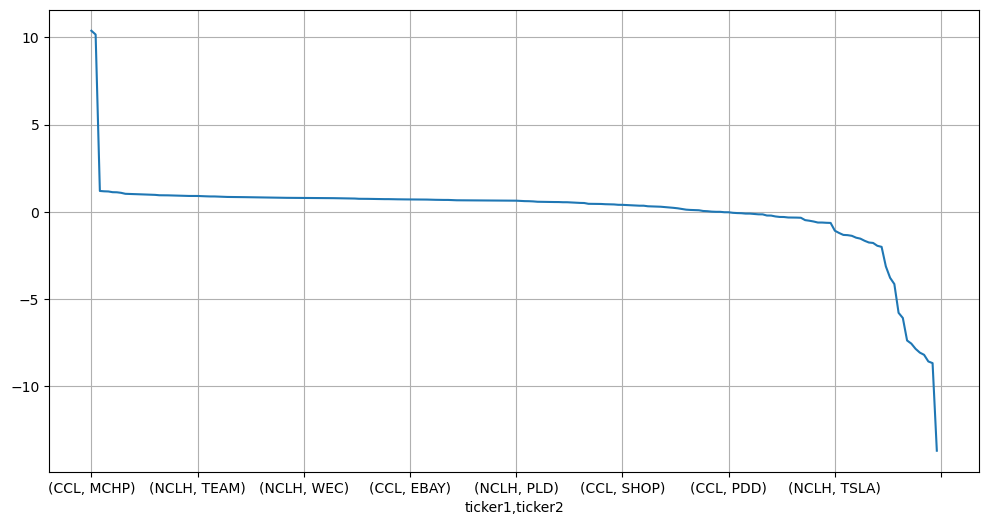

In [22]:
ranked['score'].plot(figsize=(12, 6), grid=True)

From the figure above, the elbow of the curve can be estimated to be around -3.

In [23]:
ranked_positive = ranked[ranked["score"] > -3]
robust_pairs = ranked_positive.index

In [ ]:
len(candidates), len(robust_pairs)

(200, 187)

#### Select a pair from among the ones meeting the threshold

In [25]:
import random
(ticker1, ticker2) = robust_pairs[random.randint(0, len(ranked_positive)-1)]
# (ticker1, ticker2) = robust_pairs[0]
print('Pairs:', ticker1, ticker2)

Pairs: NCLH ZTS


# 3. Generate Trading Signals

## 3.1  Extract Kalmal filter states for the selected pair & reshape prices to wide format

- df_kf = states_tr[(ticker1, ticker2)]

    Pull the Kalman output for the chosen pair from the training window.

    This DataFrame has time index and columns such as:
    - alpha, beta - time-varying intercept and hedge ratio
    - y_hat - fitted $\hat{y}_t=\alpha_t+\beta_t x_t$
    - resid - residual (aka spread) $\varepsilon_t = y_t - \hat{y}_t$

- prices = df_filtered.pivot_table(...)
    Convert the long, MultiIndex prices into a wide matrix:
        - Index: datetime
        - Columns: ticker
        - Values: close

    This makes it easy to access leg prices side-by-side, e.g. prices[[ticker1, ticker2]], and to join them with df_kf for signal generation or hedged-return calculations.

In [26]:
df_kf = states_tr[(ticker1, ticker2)]
prices = df_filtered.pivot_table(
    index=df_filtered.index.get_level_values('datetime'), 
    columns=df_filtered.index.get_level_values('ticker'), values='close'
)

## Build a pair-aligned frame: leg prices + Kalman fields

This cell constructs a **single DataFrame** with the two leg prices and the key Kalman outputs:

- P1 / P2: spot prices for ticker1 and ticker2 pulled from the wide prices matrix.
- beta / resid: time-varying hedge ratio and residual (spread) from df_kf.

In [27]:
df_pair = pd.DataFrame({
    'P1': prices[ticker1],
    'P2': prices[ticker2]
}).join(df_kf[['beta', 'resid']])

## 3.2 Generate trading signals

In [28]:
from pairs.strategies import generate_pair_signals

signals = generate_pair_signals(
    df_pair,
    z_method="robust",
    z_entry=2.0, z_exit=0.5, z_stop=4.0,
    capital_per_pair=10_000,
    max_hold_bars=None,            # set like 3*estimate_halflife(df_pair['resid'])
    cooldown_bars=0
)

In [29]:
signals

,z,pos,n1,n2,entry,exit,stop
datetime,,,,,,,
2020-01-02,NaN,0,0.0,0.0,False,False,False
2020-01-03,NaN,0,0.0,0.0,False,False,False
2020-01-06,NaN,0,0.0,0.0,False,False,False
2020-01-07,NaN,0,0.0,0.0,False,False,False
2020-01-08,NaN,0,0.0,0.0,False,False,False
...,...,...,...,...,...,...,...
2024-12-24,0.647524,0,0.0,0.0,False,True,False
2024-12-26,0.407112,0,0.0,0.0,False,False,False
2024-12-27,-0.761277,0,0.0,0.0,False,False,False


# 3.3 Visualize trading signals and compute performance metrics of strategy on training data

### 3.3.1 Plot trading signals

In [30]:
from pairs import plot_pair_legs_with_trades

(<Figure size 1300x800 with 2 Axes>,
 (<Axes: ylabel='Price (base=100)'>,
  <Axes: title={'center': 'Trades superimposed on each leg • NCLH (top), ZTS (bottom)'}, ylabel='Price (base=100)'>))

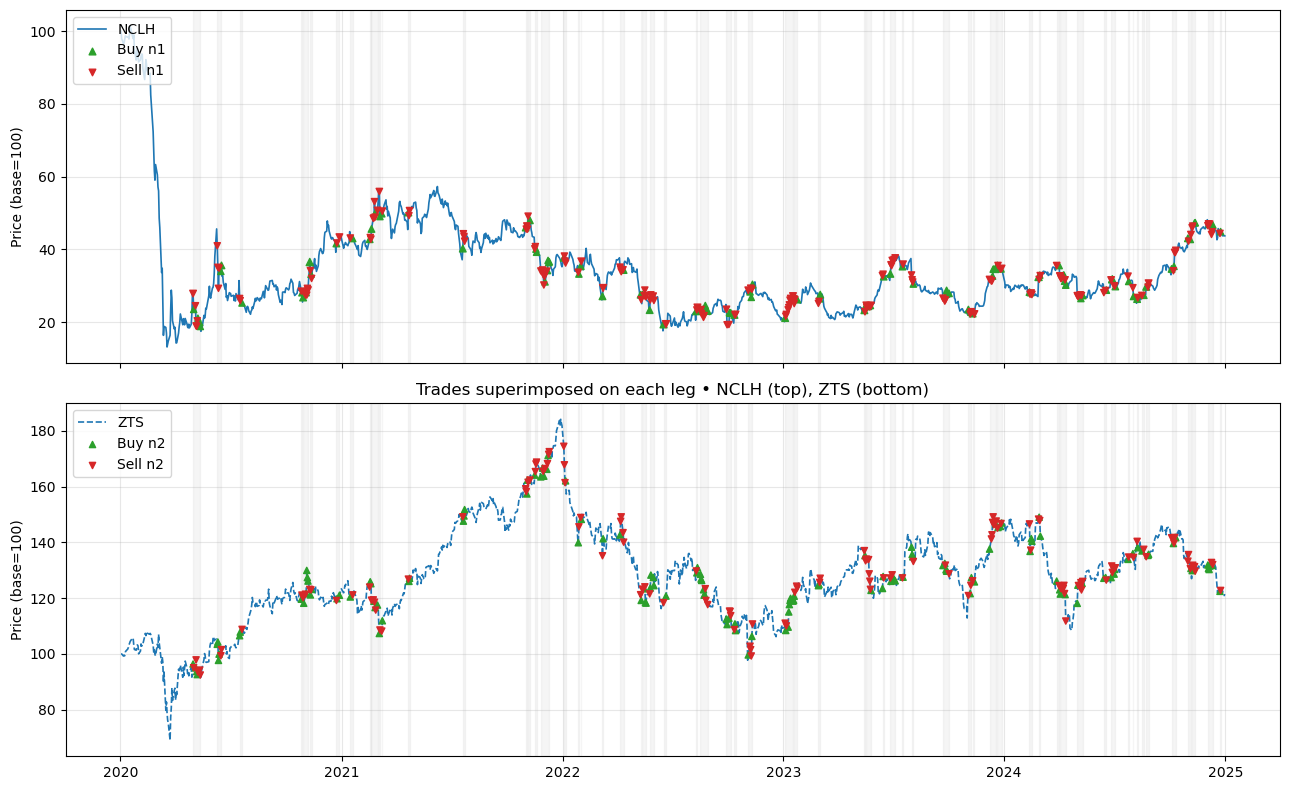

In [31]:
# df_pair: has P1,P2 columns (and optionally beta,y_hat)
# signals: from generate_pair_signals(...), has z,pos,n1,n2,entry,exit,stop

plot_pair_legs_with_trades(
    df_pair, signals,
    label1=ticker1, label2=ticker2,
    normalize=True, base_value=100,
    shade_positions=True,
    size_scale=0.004,   # tweak to taste based on your notional levels
    min_marker=20, max_marker=220
)


### 3.3.2 Compute performance metrics of strategy on training data

In [32]:
from pairs import evaluate_pair_signals

In [33]:
# df_pair has P1,P2; signals are your executed outputs (with next-bar logic)
daily, trades, summary = evaluate_pair_signals(
    df_pair, signals,
    cost_bps=1, fee_per_share_1=0.0, fee_per_share_2=0.0,
    borrow_bps_per_year=50,
    days_per_year=252,          # borrow accrual basis
    bars_per_year=252       # 390*252 for 1-min RTH scaling
)


print(pd.Series(summary))
# daily[['pnl_net','equity','drawdown_pct']].tail()
# trades.head()

start                       2020-01-02 00:00:00
end                         2024-12-31 00:00:00
bars                                       1258
capital_base                        10049.93339
gross_pnl                          28440.894567
net_pnl                            28288.909887
ann_return                             0.716169
sharpe                                 2.577388
max_drawdown                         930.966652
max_drawdown_pct                       0.067433
avg_gross_exposure                  1682.303379
avg_exposure_utilization                0.99802
turnover_annualized                   26.121446
n_trades                                     63
hit_rate                               0.920635
avg_win                              496.654709
avg_loss                             -90.813626
profit_factor                          63.43976
avg_hold_bars                          3.349206
med_hold_bars                               3.0
ann_vol                                0

# 4. Evaulate Strategy performance on out-of-sample data

## 4.1 Download or import data for the **selected pair**

In [34]:
start_test="2025-01-02"
end_test="2025-08-15"

In [35]:
df_test, failed = load_prices('openbb', [ticker1, ticker2], start_test, end_test, return_failed=True)

print(df_test.head())
if failed:
    print("No data for:", failed)

ZTS: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s] 

                    open       high        low      close   volume  dividend
ticker datetime                                                             
NCLH   2025-01-02  26.18  26.299999  25.620001  25.920000  8529800       NaN
       2025-01-03  25.85  25.990000  24.709999  25.420000  9514800       NaN
       2025-01-06  25.75  26.150000  25.350000  25.639999  9244100       NaN
       2025-01-07  25.58  25.620001  24.480000  25.510000  9142200       NaN
       2025-01-08  25.25  26.040001  25.030001  25.920000  7218800       NaN


## 4.2 Continue the Kalman filter on out-of-sample (OOS) data

Use the parameters learned on the training window to *continue* the Kalman filter on the test window, producing OOS paths for $\alpha_t$, $\beta_t$, $\hat{y}_t$ and the residual $\varepsilon_t$ **without** look-ahead.

**What we freeze from training (per pair):**
- State transition $F$, process noise $Q$, observation noise $R$ - from params_tr.
- The **last filtered** state at train end: last_state_mean, last_state_cos.

    This carries information into the test window and avoids a diffuse restart.

In [36]:
# pick the pair you trained
pair = (ticker1, ticker2)

# freeze hyperparameters learned on TRAIN
frozen = {
    "F": params_tr[pair]["F"],
    "Q": params_tr[pair]["Q"],
    "R": params_tr[pair]["R"],
}

# start the new run from the last *filtered* TRAIN state (or use None for diffuse)
last_state = (params_tr[pair]["last_state_mean"], params_tr[pair]["last_state_cov"])

# make sure P1_new, P2_new are aligned and share the same DateTimeIndex
P1_new = df_test.loc[(ticker1,), 'close']
P2_new = df_test.loc[(ticker2,), 'close']

from pairs import filter_kf_on_new

states_te, last_state_te = filter_kf_on_new(
    P1_new, P2_new,
    frozen=frozen,
    last_state=last_state,   # use None to restart diffusely if you *must*
    init_cov=1e6,
    mode="filter"            # "filter" for OOS; "smooth" only for post-hoc analysis
)


#### Join test states with test prices to prepare signals/evaluation:

In [37]:
prices_te = df_test.pivot_table(
    index=df_test.index.get_level_values("datetime"),
    columns=df_test.index.get_level_values("ticker"),
    values="close"
)
df_pair_te = states_te.join(
    prices_te[[ticker1, ticker2]].rename(columns={ticker1:"P1", ticker2:"P2"}),
    how="inner"
)

#### Generate trading signals on out-of-sample (OOS) data

In [38]:
from pairs.strategies import generate_pair_signals

signals_te = generate_pair_signals(
    df_pair_te,
    z_method="robust",
    z_entry=2.0, z_exit=0.5, z_stop=4.0,
    capital_per_pair=10_000,
    max_hold_bars=None,            # set like 3*estimate_halflife(df_pair['resid'])
    cooldown_bars=0
)

## 4.3 Plot trading signals on out-of-sample data

(<Figure size 1300x800 with 2 Axes>,
 (<Axes: ylabel='Price (base=100)'>,
  <Axes: title={'center': 'Trades superimposed on each leg • NCLH (top), ZTS (bottom)'}, ylabel='Price (base=100)'>))

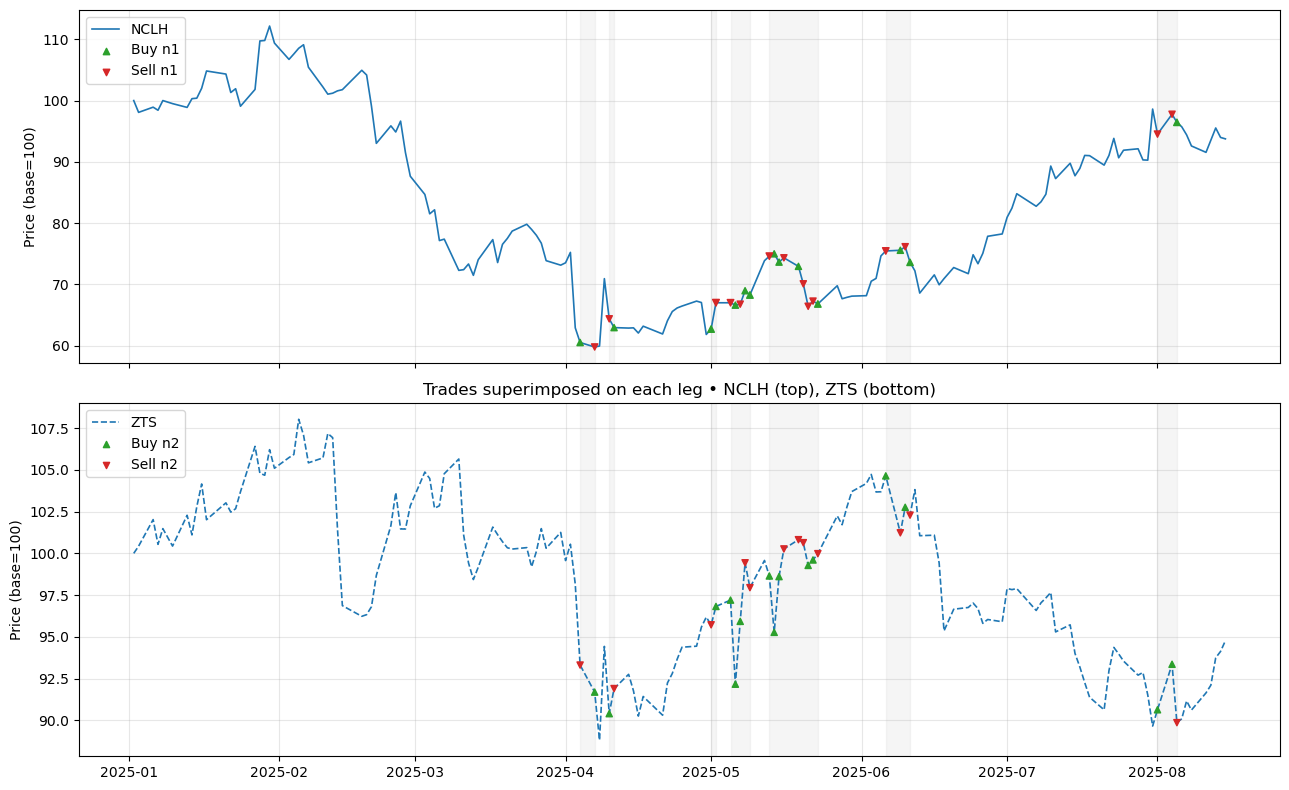

In [39]:
plot_pair_legs_with_trades(
    df_pair_te, signals_te,
    label1=ticker1, label2=ticker2,
    normalize=True, base_value=100,
    shade_positions=True,
    size_scale=0.004,   # tweak to taste based on your notional levels
    min_marker=20, max_marker=220
)

## 4.4 Evaluate strategy performance on out-of-sample data

In [40]:
# df_pair has P1,P2; signals are your executed outputs (with next-bar logic)
daily, trades, summary = evaluate_pair_signals(
    df_pair_te, signals_te,
    cost_bps=1, fee_per_share_1=0.0, fee_per_share_2=0.0,
    borrow_bps_per_year=50,
    days_per_year=252,          # borrow accrual basis
    bars_per_year=252       # 390*252 for 1-min RTH scaling
)


print(pd.Series(summary))
# daily[['pnl_net','equity','drawdown_pct']].tail()
# trades.head()

start                       2025-01-02 00:00:00
end                         2025-08-15 00:00:00
bars                                        155
capital_base                       10014.728797
gross_pnl                           1001.413841
net_pnl                              985.260103
ann_return                             0.168713
sharpe                                 1.780502
max_drawdown                         328.476505
max_drawdown_pct                       0.031375
avg_gross_exposure                  1283.574921
avg_exposure_utilization               0.993308
turnover_annualized                   22.814581
n_trades                                      7
hit_rate                               0.714286
avg_win                               233.90631
avg_loss                             -88.664366
profit_factor                          6.595274
avg_hold_bars                          2.857143
med_hold_bars                               2.0
ann_vol                                0